In [1]:
%cd ..
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # use cpu because I'm training on gpu

# from thumbs.experiments.pokemjon_big_both import PokemonExperiment
from thumbs.experiments.pokemon_wgan_deep import PokemonExperiment
from thumbs.train import load_weights
from thumbs.viz import show_samples, visualize_preprocessed_image
from thumbs.data import load_and_preprocess_image
import tensorflow as  tf
import numpy as np
import matplotlib.pyplot as plt



/home/anthony/workspace/yt-data


/home/anthony/workspace/yt-data/.venv/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Images in /home/anthony/workspace/yt-data/data/pokemon
['282-mega.jpg', '582.jpg', '340.jpg', '570.jpg', '136.jpg', '531-mega.jpg', '335.jpg', '96.jpg', '581.jpg', '153.jpg']
Found 821 total files
Found 819 jpgs


  0%|          | 0/819 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

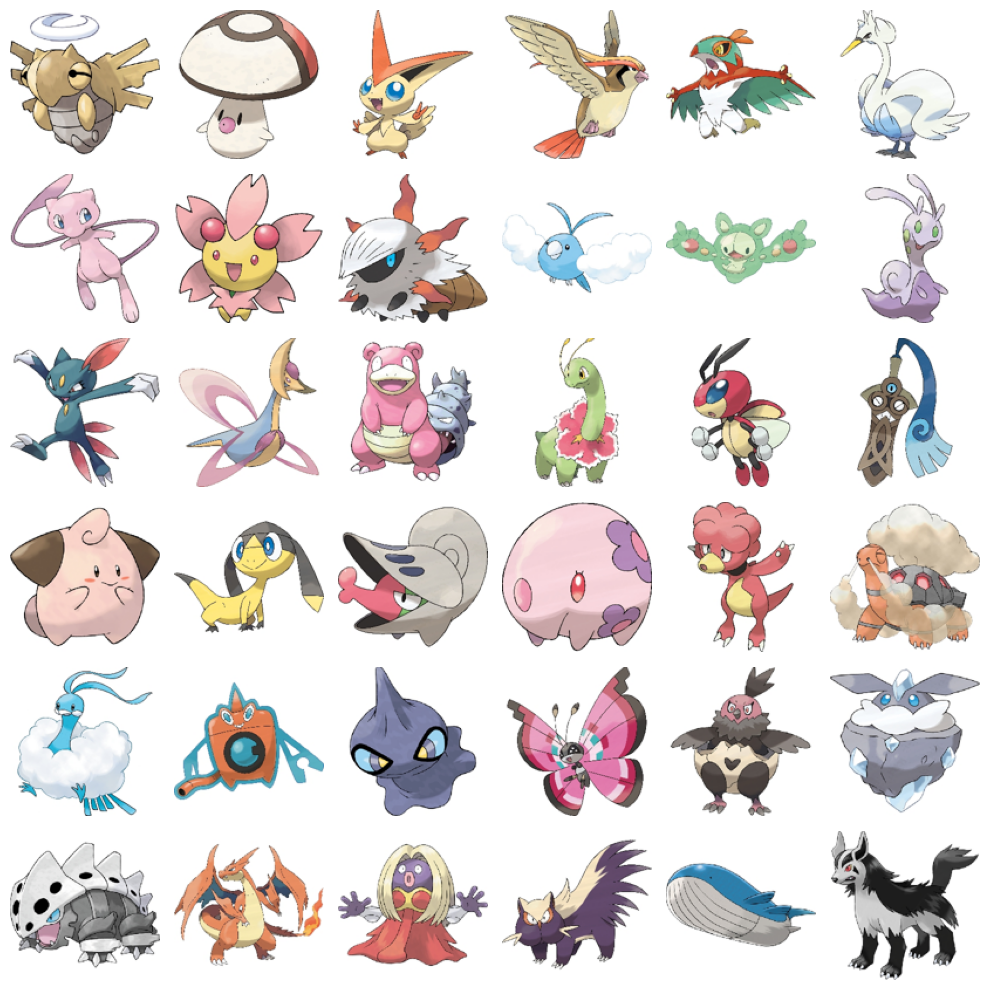

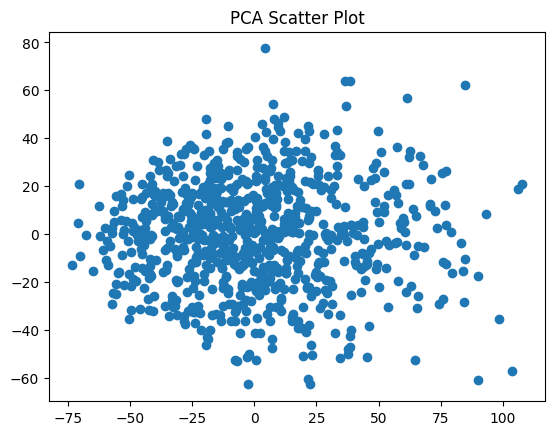

2023-07-25 10:42:12.349052: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "discriminator"
________________________________________________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                                     Output Shape                                Param #                 Connected to                                                      
 img_input (InputLayer)                                           [(None, 128, 128, 3)]                       0                       []                                                                
                                                                                                                                                                                                        
 diff_augment_layer (DiffAugmentLayer)                            (None, 128, 128, 3)                         0                       ['img_input[0][0]']                    

In [2]:
exp = PokemonExperiment()
mparams = exp.get_mutable_params()
m = exp.get_model(mparams[0]).build()
load_weights(m.generator, exp.get_params().gen_weight_path)
load_weights(m.discriminator, exp.get_params().dis_weight_path)

# Make a fake pokemon and judge it

<Figure size 640x480 with 0 Axes>

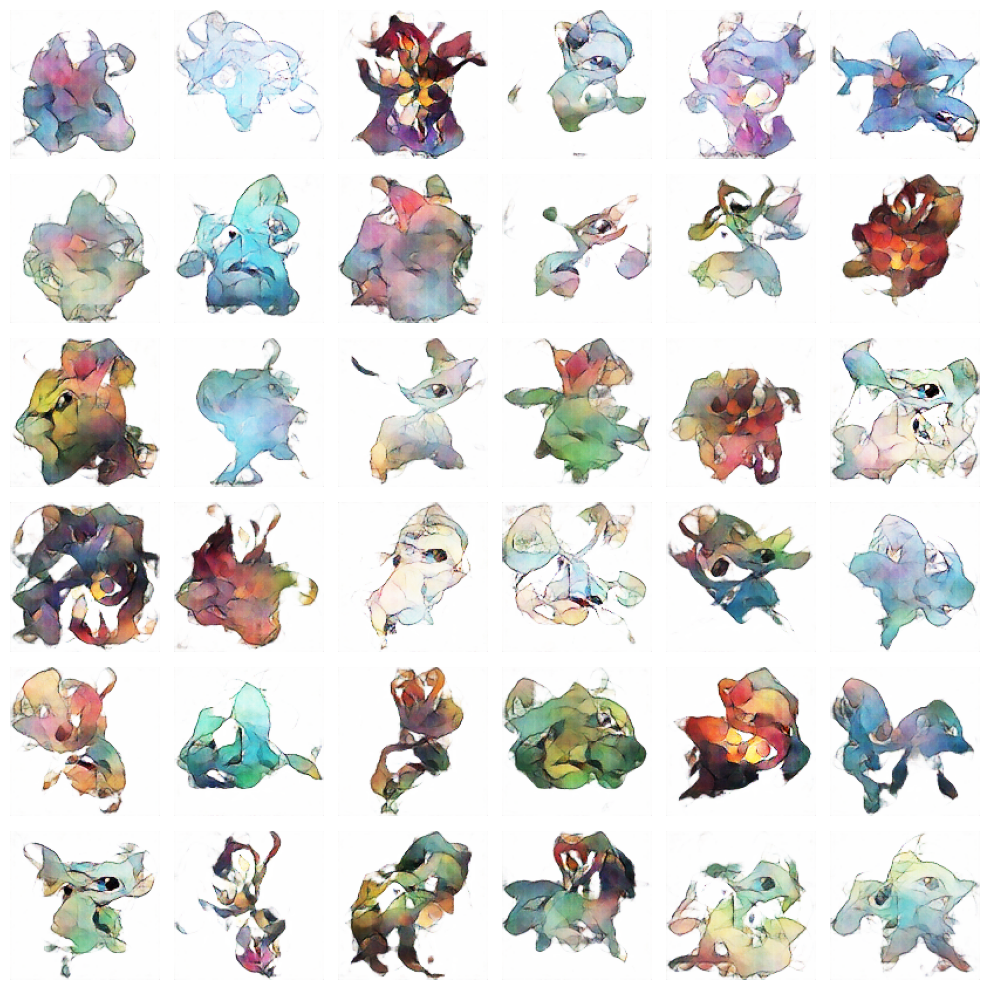

In [3]:
show_samples(m.generator, exp.get_params().latent_dim, rows=6, cols=6, file_name="tmp.jpg", dir="/tmp")

1/1 [==============================] - 0s 37ms/step


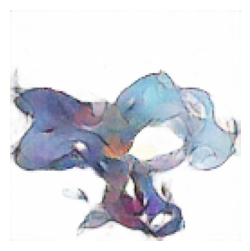

1/1 [==============================] - 0s 284ms/step
[[213.39462]]


In [4]:

noise = np.random.normal(0, 1, (1, 100))
generated_thumbnails = m.generator.predict(noise)
visualize_preprocessed_image(generated_thumbnails[0], (3,3))
print(m.discriminator.predict(generated_thumbnails))


In [5]:
# mean of a lot of generated images
noise = np.random.normal(0, 1, (800, 100))
generated_thumbnails = m.generator.predict(noise)
print(np.mean(m.discriminator.predict(generated_thumbnails)))

25/25 [==============================] - 10s 397ms/step
216.2684


# Determine attribution

In [6]:

# Define a function to compute the attribution maps using Gradient*Input method
def compute_attribution_map(image: np.ndarray):
    image = tf.convert_to_tensor(image)
    with tf.GradientTape() as tape:
        tape.watch(image)
        output = m.discriminator(image)
    
    gradients = tape.gradient(output, image)
    attribution_map = gradients * image
    
    return attribution_map

def show_attribution(input_image):
    preprocessed_image = np.expand_dims(input_image, axis=0)  # Add batch dimension

    # Compute the attribution map for the input image
    attribution_map = compute_attribution_map(preprocessed_image)
    # Convert the attribution map to a grayscale image
    attribution_map = np.mean(attribution_map, axis=-1, keepdims=True)

    # Normalize the attribution map to [0, 1]
    attribution_map -= np.min(attribution_map)
    attribution_map /= np.max(attribution_map)

    # Resize the attribution map to the original image size for visualization
    attribution_map = tf.image.resize(attribution_map, size=(128, 128)).numpy()


    # Convert them back to 0,255. The pokemon images look better that way, just keep
    # the attribution map consistent
    input_image = ((input_image + 1) * 127.5).astype(np.uint8)


    # Display the original image and the attribution map
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(input_image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    axes[1].imshow(attribution_map.squeeze(axis=0), cmap='bwr')
    axes[1].set_title('Attribution Map')
    axes[1].axis('off')
    plt.show()


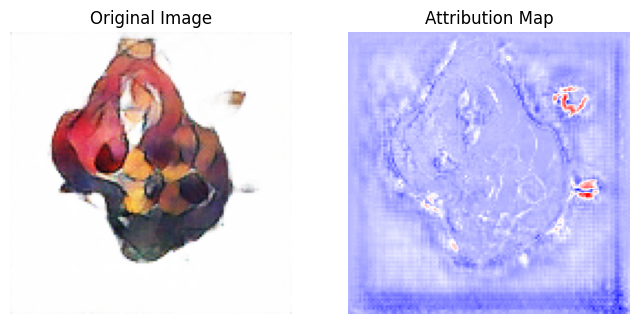

In [7]:

show_attribution(generated_thumbnails[0])

### Sanity check against an absurd image

1/1 [==============================] - 0s 55ms/step
[[220.62341]]


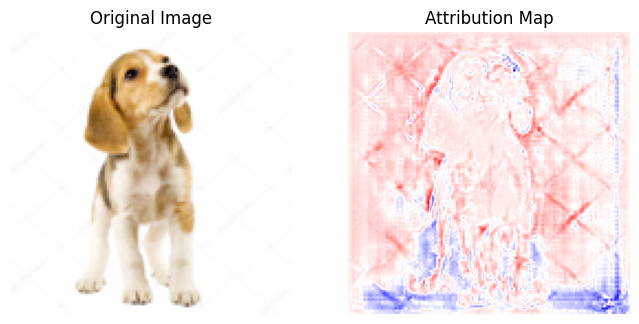

In [8]:
# load 
egg_jpg = '/home/anthony/windows/Downloads/dog_white.jpg'
egg = load_and_preprocess_image(egg_jpg, (128, 128, 3))

print(m.discriminator.predict(np.expand_dims(egg, axis=0)))
show_attribution(egg)

# Judge a real pokemon

Images in /home/anthony/workspace/yt-data/data/pokemon
['282-mega.jpg', '582.jpg', '340.jpg', '570.jpg', '136.jpg', '531-mega.jpg', '335.jpg', '96.jpg', '581.jpg', '153.jpg']
Found 821 total files
Found 819 jpgs


  0%|          | 0/819 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

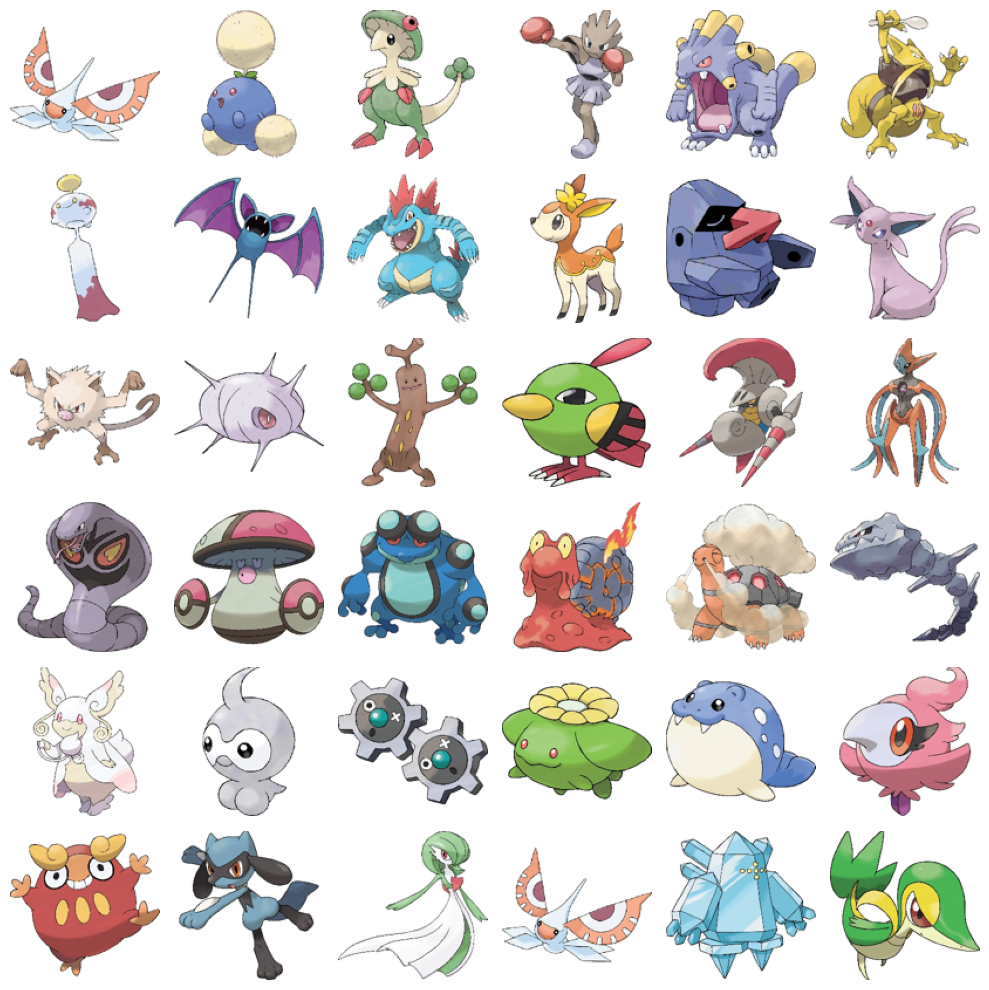

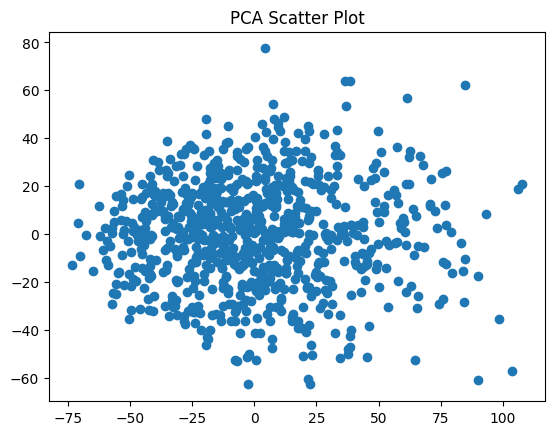

(819, 128, 128, 3)

In [9]:
from thumbs.data import get_pokemon_data256
images = get_pokemon_data256(exp.get_params().img_shape)
images.shape

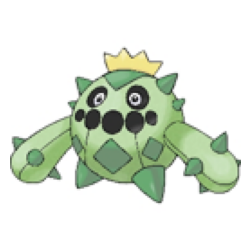

1/1 [==============================] - 0s 60ms/step
[[230.6639]]


In [10]:
real_pokemon = images[np.random.randint(0, images.shape[0], 1)]
visualize_preprocessed_image(real_pokemon[0], (3,3))

print(m.discriminator.predict(real_pokemon))



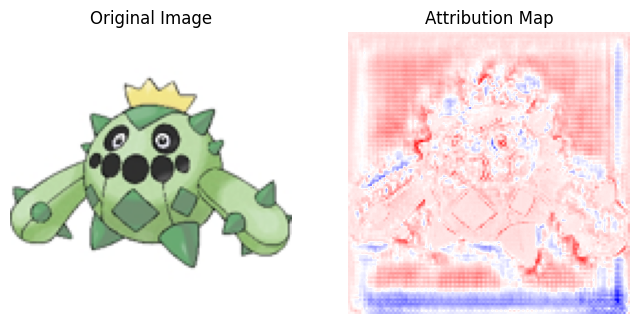

In [11]:

show_attribution(real_pokemon[0])

In [12]:

# Mean of the entire real set
print(np.mean(m.discriminator.predict(images)))

26/26 [==============================] - 11s 402ms/step
233.1738


# Get FID score

In [13]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from scipy.linalg import sqrtm

def calculate_fid(model, images1, images2):
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)

    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)

    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))

    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [14]:
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=exp.get_params().img_shape)

In [15]:
real_images = images
fake_images = m.generator.predict(np.random.normal(0, 1, (real_images.shape[0], 100)))
fid = calculate_fid(inception_model, real_images, fake_images)
fid

26/26 [==============================] - 3s 109ms/step


1525.6705402412465

# Inspect Generator hidden layer output

In [19]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

def get_intermediate_models(model):
    intermediate_models = []
    # layers_to_get = [2,5,8,11, 12]
    for i in range(len(model.layers)):
        # only pick models that have conv2d_transpose_1 or tanh in the name
        layer = model.layers[i]
        if 'conv2d' in layer.output.name.lower() or 'tanh' in layer.output.name.lower() or len(layer.output.shape) == 4:
            print(model.layers[i])
            intermediate_model = Model(inputs=model.input, outputs=model.layers[i].output)
            intermediate_models.append(intermediate_model)
    return intermediate_models


def inspect_layers(model, input):
    intermediate_models = get_intermediate_models(model)
    for i, intermediate_model in enumerate(intermediate_models):
        print(f'Layer {i+1} of {len(intermediate_models)}, shape {intermediate_model.output_shape}, name {intermediate_model.output.name}')
        intermediate_output = intermediate_model.predict(input, verbose=0)

        intermediate_output = intermediate_output[0]
        # n = 64
        # intermediate_output = intermediate_output[:, :, :n]

        intermediate_output -= intermediate_output.min() # Make the minimum 0
        intermediate_output /= intermediate_output.max() # Make the maximum 1

        n_cols = 4
        n_channels = min(n_cols, intermediate_output.shape[2])
        fig, axs = plt.subplots(n_channels , n_cols, figsize=(8, 8))
        for i in range(n_channels):
            for j in range(n_cols):
                if n_channels == 3:
                    axs[i][j].imshow(intermediate_output)
                else:
                    axs[i][j].imshow(intermediate_output[:, :, np.random.randint(0, intermediate_output.shape[2])])
                axs[i][j].axis('off')

        plt.show()



Layer 1 of 5, shape (None, 16, 16, 512), name conv2d_transpose/conv2d_transpose:0


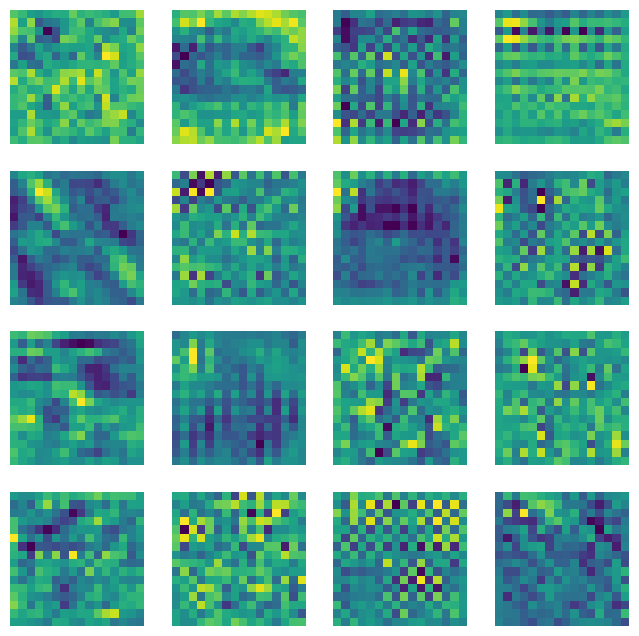

Layer 2 of 5, shape (None, 32, 32, 256), name conv2d_transpose_1/conv2d_transpose:0


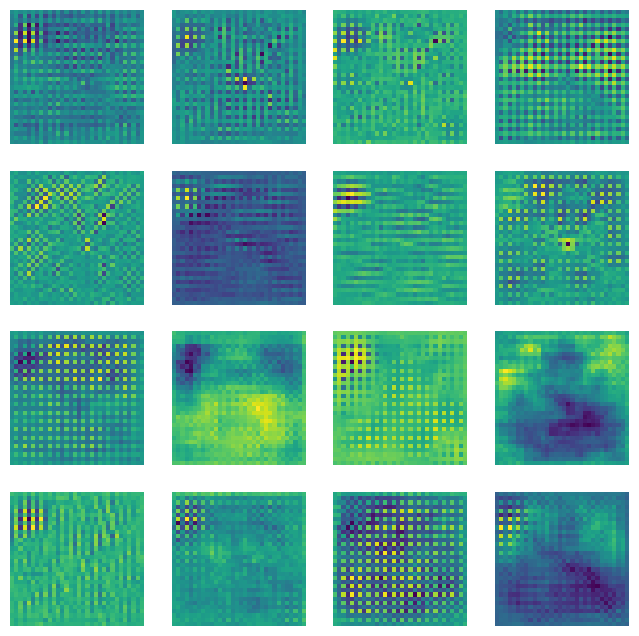

Layer 3 of 5, shape (None, 64, 64, 128), name conv2d_transpose_2/conv2d_transpose:0


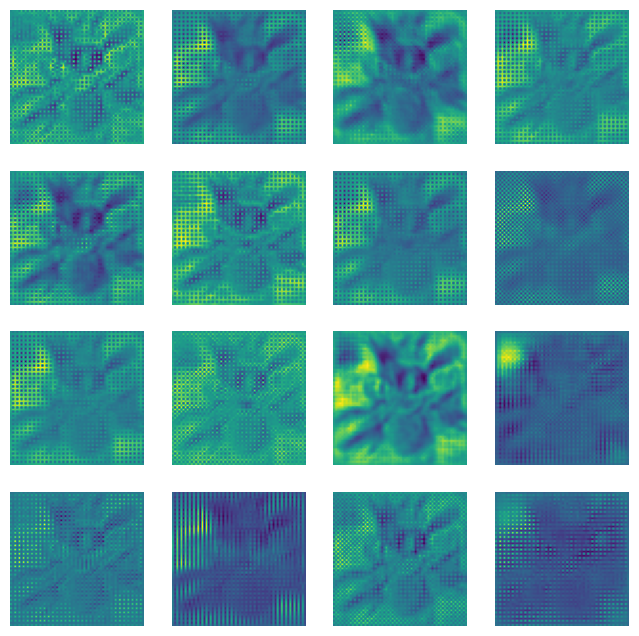

Layer 4 of 5, shape (None, 128, 128, 3), name conv2d_transpose_3/BiasAdd:0


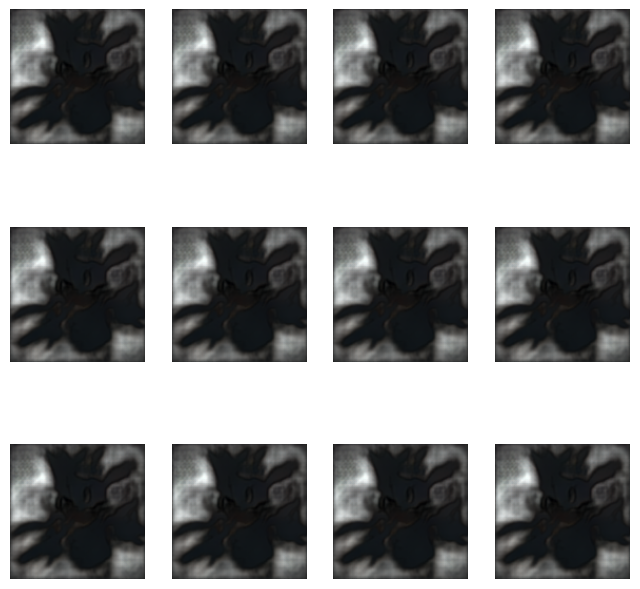

Layer 5 of 5, shape (None, 128, 128, 3), name activation/Tanh:0


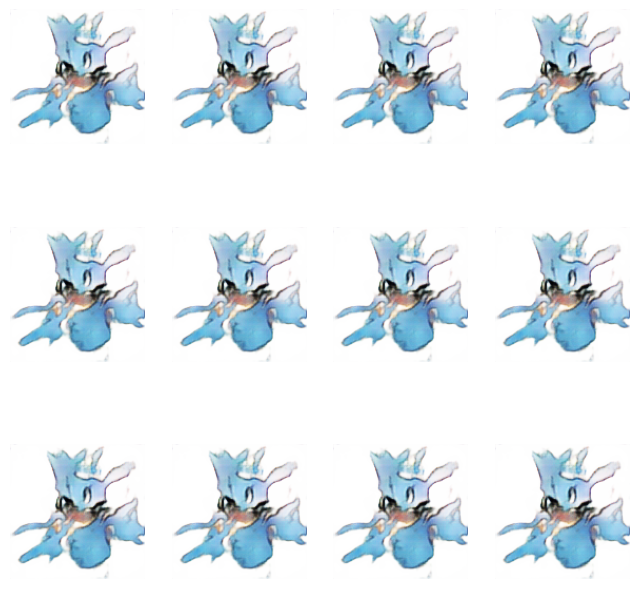

In [20]:

noise = np.random.normal(0, 1, (1, 100))
inspect_layers(m.generator, noise)

 # Inspect Discriminator hidden layers

1/1 [==============================] - 0s 34ms/step


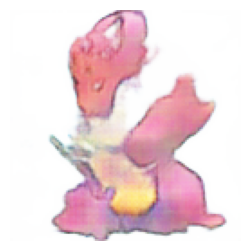

Layer 1 of 4, shape (None, 64, 64, 128), name conv2d/Conv2D:0


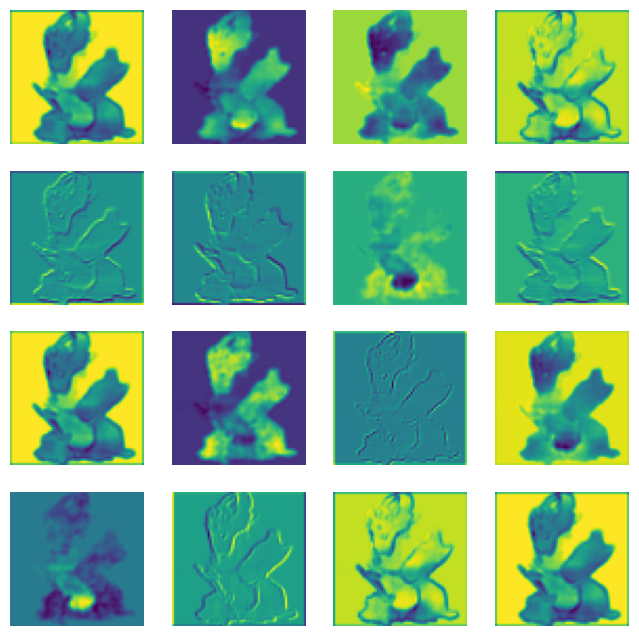

Layer 2 of 4, shape (None, 32, 32, 256), name conv2d_1/Conv2D:0


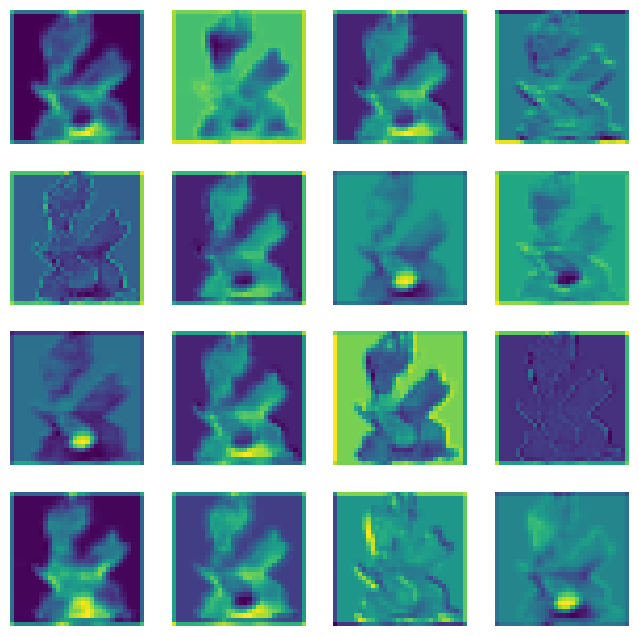

Layer 3 of 4, shape (None, 16, 16, 512), name conv2d_2/Conv2D:0


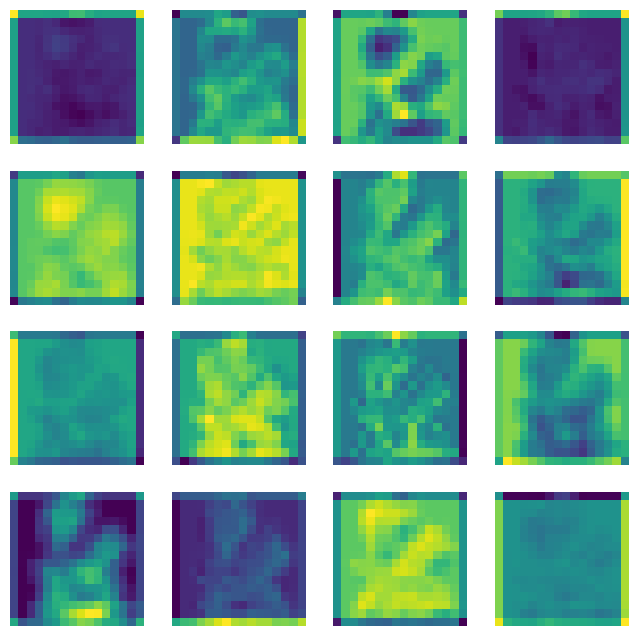

Layer 4 of 4, shape (None, 8, 8, 1024), name conv2d_3/Conv2D:0


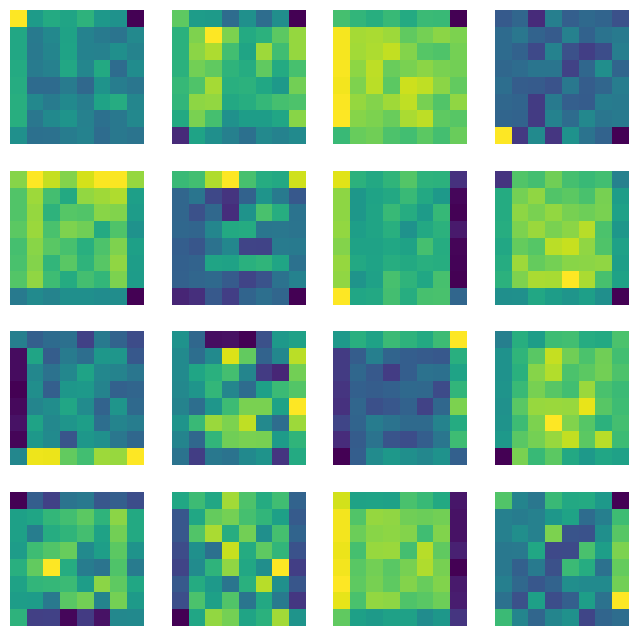

In [22]:
noise = np.random.normal(0, 1, (1, 100))
generated_image = m.generator.predict(noise)
visualize_preprocessed_image(generated_image[0], (3,3))

inspect_layers(m.discriminator, generated_image)
